In [1]:
import requests
import numpy as np
import pandas as pd
import pickle
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, cross_val_score, KFold
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Range of years
start_year = 2015
end_year = 2023
current_year = 2023

In [2]:
# Load the dataframe
with open('dataframe.pickle','rb') as file:
    data = pickle.load(file)

print(data.shape)

(5397, 88)


In [74]:
# Method to conviently fetch data from different CFBD endpoints 
def get_api_data(endpoint, params=None):
    base_url = "https://api.collegefootballdata.com"
    url = base_url + endpoint

    api_key = "h2jcXh77WoIog0ba1MdofV5zcg0L0I8NHC3EMmnymPP5G3xF/LxHn+x3asvvSIo2"

    headers = {
        "Authorization": f"Bearer {api_key}"
    }

    response = requests.get(url, params=params, headers=headers)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"Request failed with status code: {response.status_code}")
        return None

In [19]:
# List to store game data
games = []

# Iterate through the years, make API requests, and only collect the relevant features
for year in range(start_year, end_year + 1):
    params = {
        "year": year,
        "seasonType": "regular",
    }
    
    games_data = get_api_data("/games", params)

    # Checking if the request was successful (status code 200)
    if games_data:
        for g in games_data:
            if g['home_conference'] is not None and g['away_conference'] is not None and g['home_points'] is not None and g['away_points'] is not None:
                games.append({
                    'id': g['id'],
                    'year': g['season'],
                    'week': g['week'],
                    'neutral_site': g['neutral_site'],
                    'home_team': g['home_team'],
                    'home_conference': g['home_conference'],
                    'home_points': g['home_points'],
                    'home_elo': g['home_pregame_elo'],
                    'away_team': g['away_team'],
                    'away_conference': g['away_conference'],
                    'away_points': g['away_points'],
                    'away_elo': g['away_pregame_elo']
                })

# Create a DataFrame from the list of game data
data = pd.DataFrame(games).dropna()
data['margin'] = data['away_points'] - data['home_points']
data.head()

,id,year,week,neutral_site,home_team,home_conference,home_points,home_elo,away_team,away_conference,away_points,away_elo,margin
1,400763593,2015,1,False,UCF,American Athletic,14,1626.0,Florida International,Conference USA,15,1321.0,1
2,400603840,2015,1,True,South Carolina,SEC,17,1646.0,North Carolina,ACC,13,1477.0,-4
4,400763399,2015,1,False,Central Michigan,Mid-American,13,1417.0,Oklahoma State,Big 12,24,1567.0,11
15,400603839,2015,1,False,Vanderbilt,SEC,12,1365.0,Western Kentucky,Conference USA,14,1521.0,2
16,400756883,2015,1,False,Utah,Pac-12,24,1603.0,Michigan,Big Ten,17,1553.0,-7


In [20]:
# Collect data for the consensus spread of the games
for year in range(start_year, end_year + 1):
    params = {
        "year": year
    }
    
    betting_data = get_api_data("/lines", params)

    for betting_line in betting_data:
        if betting_line['lines'] and any(l['provider'] == 'consensus' for l in betting_line['lines']):
            consensus_spread = next(l['spread'] for l in betting_line['lines'] if l['provider'] == 'consensus')
            data.loc[data['id'] == betting_line['id'], 'spread'] = float(consensus_spread) if consensus_spread is not None else None

data.head()

,id,year,week,neutral_site,home_team,home_conference,home_points,home_elo,away_team,away_conference,away_points,away_elo,margin,spread
1,400763593,2015,1,False,UCF,American Athletic,14,1626.0,Florida International,Conference USA,15,1321.0,1,-17.0
2,400603840,2015,1,True,South Carolina,SEC,17,1646.0,North Carolina,ACC,13,1477.0,-4,-3.5
4,400763399,2015,1,False,Central Michigan,Mid-American,13,1417.0,Oklahoma State,Big 12,24,1567.0,11,20.5
15,400603839,2015,1,False,Vanderbilt,SEC,12,1365.0,Western Kentucky,Conference USA,14,1521.0,2,-17.5
16,400756883,2015,1,False,Utah,Pac-12,24,1603.0,Michigan,Big Ten,17,1553.0,-7,-3.0


In [21]:
# Create a dictionary to collect roster talent data
talent_dict = {}

# Collect data for the 247 roster talent ratings
for year in range(start_year, end_year + 1):
    params = {
        "year": year
    }
    
    talent_data = get_api_data("/talent", params)

    for talent in talent_data:
        key = (talent['school'], talent['year'])
        if key not in talent_dict:
            talent_dict[key] = talent['talent']

# Map the talent data to the DataFrame based on 'school' and 'year'
data['home_talent'] = data.apply(lambda row: talent_dict.get((row['home_team'], row['year']), None), axis=1)
data['away_talent'] = data.apply(lambda row: talent_dict.get((row['away_team'], row['year']), None), axis=1)

# Convert 'home_talent' and 'away_talent' columns to float
data['home_talent'] = data['home_talent'].astype(float)
data['away_talent'] = data['away_talent'].astype(float)

data.head()

,id,year,week,neutral_site,home_team,home_conference,home_points,home_elo,away_team,away_conference,away_points,away_elo,margin,spread,home_talent,away_talent
1,400763593,2015,1,False,UCF,American Athletic,14,1626.0,Florida International,Conference USA,15,1321.0,1,-17.0,484.54,360.11
2,400603840,2015,1,True,South Carolina,SEC,17,1646.0,North Carolina,ACC,13,1477.0,-4,-3.5,725.72,683.03
4,400763399,2015,1,False,Central Michigan,Mid-American,13,1417.0,Oklahoma State,Big 12,24,1567.0,11,20.5,376.81,651.83
15,400603839,2015,1,False,Vanderbilt,SEC,12,1365.0,Western Kentucky,Conference USA,14,1521.0,2,-17.5,609.76,353.50
16,400756883,2015,1,False,Utah,Pac-12,24,1603.0,Michigan,Big Ten,17,1553.0,-7,-3.0,574.41,851.12


In [22]:
# Create a dictionary to collect poll ranking data
rankings_dict = {}

# Only consider the AP Top 25 poll and Coaches Poll
unique_poll_names = set(['AP Top 25','Coaches Poll'])

# Collect data for the polls
for year in range(start_year, end_year + 1):
    params = {
        "year": year
    }
    
    rankings_data = get_api_data("/rankings", params)

    for rr in rankings_data:
        for poll in rr['polls']:
            if poll['poll'] in unique_poll_names:
                for rank in poll['ranks']:
                    key = (rank['school'], rr['season'], rr['week'], poll['poll'])
                    rankings_dict[key] = rank['points']

# Map the ranking data to the DataFrame based on 'home_team' or 'away_team','year', and 'week'
for poll_name in unique_poll_names:
    home_column_name = f'home_{poll_name.replace(" ", "_").lower()}_points'
    away_column_name = f'away_{poll_name.replace(" ", "_").lower()}_points'
    data[home_column_name] = data.apply(
        lambda row: rankings_dict.get((row['home_team'], row['year'], row['week'], poll_name), 0),
        axis=1
    )
    data[away_column_name] = data.apply(
        lambda row: rankings_dict.get((row['away_team'], row['year'], row['week'], poll_name), 0),
        axis=1
    )
    
data.head()

,id,year,week,neutral_site,home_team,home_conference,home_points,home_elo,away_team,away_conference,away_points,away_elo,margin,spread,home_talent,away_talent,home_ap_top_25_points,away_ap_top_25_points,home_coaches_poll_points,away_coaches_poll_points
1,400763593,2015,1,False,UCF,American Athletic,14,1626.0,Florida International,Conference USA,15,1321.0,1,-17.0,484.54,360.11,0,0,0,0
2,400603840,2015,1,True,South Carolina,SEC,17,1646.0,North Carolina,ACC,13,1477.0,-4,-3.5,725.72,683.03,0,0,0,0
4,400763399,2015,1,False,Central Michigan,Mid-American,13,1417.0,Oklahoma State,Big 12,24,1567.0,11,20.5,376.81,651.83,0,0,0,0
15,400603839,2015,1,False,Vanderbilt,SEC,12,1365.0,Western Kentucky,Conference USA,14,1521.0,2,-17.5,609.76,353.50,0,0,0,0
16,400756883,2015,1,False,Utah,Pac-12,24,1603.0,Michigan,Big Ten,17,1553.0,-7,-3.0,574.41,851.12,0,0,0,0


In [23]:
# Collect data for the cumulative basic stats for each team for each week (e.g. number of turnovers from weeks 1 to 5 in the week 6 row)
max_week = data['week'].max()
season_stats_dict = {}
# Only get these basic stats
stat_name_mappings = {
    'possessionTime': 'possession_time',
    'turnovers': 'turnovers',
    'penalties': 'penalties',
    'sacks': 'sacks',
    'tacklesForLoss': 'tackles_for_loss',
    'firstDowns': 'first_downs',
    'thirdDowns': 'third_downs',
    'fourthDowns': 'fourth_downs',
    'thirdDownConversions': 'third_down_conversions',
    'fourthDownConversions': 'fourth_down_conversions',
    'passAttempts': 'pass_attempts',
    'passCompletions': 'pass_completions',
    'netPassingYards': 'net_passing_yards',
    'passingTDs': 'passing_TDs',
    'rushingAttempts': 'rushing_attempts',
    'rushingYards': 'rushing_yards',
    'rushingTDs': 'rushing_TDs',
    'totalYards': 'total_yards'
}
# Collect the basic stats data
for year in range(start_year, end_year + 1):
    print("Fetching data for year: ", year)
    for week in range (1, max_week):
        params = {
            "year": year,
            "startWeek": 1,
            "endWeek": week
        }
        season_stats_data = get_api_data("/stats/season", params)
        
        for team_stat in season_stats_data:
            if 'statName' in team_stat and team_stat['statName'] in stat_name_mappings:
                key = (team_stat['team'], team_stat['season'], week, stat_name_mappings[team_stat['statName']])
                season_stats_dict[key] = team_stat['statValue']
                
# Map the basic stats data to the teams, offset by a week to not include the current week's data
for stat in stat_name_mappings.values():
    home_column_name = f'home_cumulative_{stat}'
    away_column_name = f'away_cumulative_{stat}'
    data[home_column_name] = data.apply(
        lambda row: season_stats_dict.get((row['home_team'], row['year'], row['week'] - 1, stat), 0),
        axis=1
    )
    data[away_column_name] = data.apply(
        lambda row: season_stats_dict.get((row['away_team'], row['year'], row['week'] - 1, stat), 0),
        axis=1
    )

# Since the head would have 0 for all of the stats since it's the first game of the season, look by a team
data[(data['year'] == 2022) & ((data['home_team'] == 'Florida') | (data['away_team'] == 'Florida'))]

Fetching data for year:  2015
Fetching data for year:  2016
Fetching data for year:  2017
Fetching data for year:  2018
Fetching data for year:  2019
Fetching data for year:  2020
Fetching data for year:  2021
Fetching data for year:  2022
Fetching data for year:  2023


,id,year,week,neutral_site,home_team,home_conference,home_points,home_elo,away_team,away_conference,...,home_cumulative_passing_TDs,away_cumulative_passing_TDs,home_cumulative_rushing_attempts,away_cumulative_rushing_attempts,home_cumulative_rushing_yards,away_cumulative_rushing_yards,home_cumulative_rushing_TDs,away_cumulative_rushing_TDs,home_cumulative_total_yards,away_cumulative_total_yards
10640,401403857,2022,1,False,Florida,SEC,29,1572.0,Utah,Pac-12,...,0,0,0,0,0,0,0,0,0,0
10929,401403871,2022,2,False,Florida,SEC,16,1576.0,Kentucky,SEC,...,0,3,39,26,283,50,4,0,451,353
11273,401403883,2022,3,False,Florida,SEC,31,1567.0,South Florida,American Athletic,...,0,0,69,54,419,312,5,8,730,703
11478,401403901,2022,4,False,Tennessee,SEC,38,1835.0,Florida,SEC,...,9,0,131,99,547,636,12,8,1661,1059
11910,401403910,2022,6,False,Florida,SEC,24,1569.0,Missouri,SEC,...,5,5,169,187,1051,847,15,8,2319,1873
12461,401403917,2022,7,False,Florida,SEC,35,1572.0,LSU,SEC,...,6,8,201,222,1282,1034,16,16,2616,2572
13030,401403928,2022,9,True,Georgia,SEC,42,2154.0,Florida,SEC,...,11,7,246,234,1377,1492,24,20,3686,3011
13100,401403937,2022,10,False,Texas A&M,SEC,24,1655.0,Florida,SEC,...,13,8,229,268,992,1592,7,21,2879,3382
13390,401403941,2022,11,False,Florida,SEC,38,1604.0,South Carolina,SEC,...,10,11,318,297,1883,1228,24,22,3874,3314
13468,401403955,2022,12,False,Vanderbilt,SEC,31,1298.0,Florida,SEC,...,19,12,352,372,1597,2257,13,27,3630,4389


In [24]:
# Collect data for the cumulative advanced stats for each team for each week (e.g. X from weeks 1 to 5 in the week 6 row)
max_week = data['week'].max()
season_adv_stats_dict = {}

# Only get these advanced stats
adv_stat_name_mappings = {
    'drives': 'drives',
    'ppa': 'ppa',
    'successRate': 'success_rate',
    'explosiveness': 'explosiveness',
    'pointsPerOpportunity': 'points_per_opportunity',
    'stuffRate': 'stuff_rate',
    'fieldPosition': 'field_position_average_predicted_points',
    'havoc': 'havoc',
}

# Collect the basic stats data
for year in range(start_year, end_year + 1):
    print("Fetching data for year: ", year)
    for week in range (1, max_week):
        params = {
            "year": year,
            "startWeek": 1,
            "endWeek": week
        }
        season_adv_stats_data = get_api_data("/stats/season/advanced", params)
        
        for team_stat in season_adv_stats_data:
            if 'offense' in team_stat:
                for offense_stat, value in team_stat['offense'].items():
                    if offense_stat in adv_stat_name_mappings:
                        stat_value = value
                        if offense_stat == 'havoc':
                            stat_value = value['total']
                        elif offense_stat == 'fieldPosition':
                            stat_value = value['averagePredictedPoints']
                        key = (team_stat['team'], team_stat['season'], week, 'offense_' + adv_stat_name_mappings[offense_stat])
                        season_adv_stats_dict[key] = stat_value
            if 'defense' in team_stat:
                for offense_stat, value in team_stat['defense'].items():
                    if offense_stat in adv_stat_name_mappings:
                        stat_value = value
                        if offense_stat == 'havoc':
                            stat_value = value['total']
                        elif offense_stat == 'fieldPosition':
                            stat_value = value['averagePredictedPoints']
                        key = (team_stat['team'], team_stat['season'], week, 'defense_' + adv_stat_name_mappings[offense_stat])
                        season_adv_stats_dict[key] = stat_value

# Map the basic stats data to the teams, offset by a week to not include the current week's data
for stat in adv_stat_name_mappings.values():
    home_offense_column_name = f'home_cumulative_offense_{stat}'
    away_offense_column_name = f'away_cumulative_offense_{stat}'
    home_defense_column_name = f'home_cumulative_defense_{stat}'
    away_defense_column_name = f'away_cumulative_defense_{stat}'
    data[home_offense_column_name] = data.apply(
        lambda row: season_adv_stats_dict.get((row['home_team'], row['year'], row['week'] - 1, 'offense_' + stat), 0),
        axis=1
    )
    data[away_offense_column_name] = data.apply(
        lambda row: season_adv_stats_dict.get((row['away_team'], row['year'], row['week'] - 1, 'offense_' + stat), 0),
        axis=1
    )
    data[home_defense_column_name] = data.apply(
        lambda row: season_adv_stats_dict.get((row['home_team'], row['year'], row['week'] - 1, 'defense_' + stat), 0),
        axis=1
    )
    data[away_defense_column_name] = data.apply(
        lambda row: season_adv_stats_dict.get((row['away_team'], row['year'], row['week'] - 1, 'defense_' + stat), 0),
        axis=1
    )

# Since the head would have 0 for all of the stats since it's the first game of the season, look by a team
data[(data['year'] == 2022) & ((data['home_team'] == 'Florida') | (data['away_team'] == 'Florida'))]

Fetching data for year:  2015
Fetching data for year:  2016
Fetching data for year:  2017
Fetching data for year:  2018
Fetching data for year:  2019
Fetching data for year:  2020
Fetching data for year:  2021
Fetching data for year:  2022
Fetching data for year:  2023


,id,year,week,neutral_site,home_team,home_conference,home_points,home_elo,away_team,away_conference,...,home_cumulative_defense_stuff_rate,away_cumulative_defense_stuff_rate,home_cumulative_offense_field_position_average_predicted_points,away_cumulative_offense_field_position_average_predicted_points,home_cumulative_defense_field_position_average_predicted_points,away_cumulative_defense_field_position_average_predicted_points,home_cumulative_offense_havoc,away_cumulative_offense_havoc,home_cumulative_defense_havoc,away_cumulative_defense_havoc
10640,401403857,2022,1,False,Florida,SEC,29,1572.0,Utah,Pac-12,...,0.000000,0.000000,0.000,0.000,0.000,0.000,0.000000,0.000000,0.000000,0.000000
10929,401403871,2022,2,False,Florida,SEC,16,1576.0,Kentucky,SEC,...,0.153846,0.178571,0.660,1.418,-1.538,-1.056,0.064516,0.109091,0.070423,0.158730
11273,401403883,2022,3,False,Florida,SEC,31,1567.0,South Florida,American Athletic,...,0.175676,0.236111,0.943,1.553,-1.498,-1.121,0.118110,0.110092,0.112782,0.183099
11478,401403901,2022,4,False,Tennessee,SEC,38,1835.0,Florida,SEC,...,0.292683,0.122951,1.429,1.053,-1.349,-1.527,0.103004,0.118644,0.181818,0.119617
11910,401403910,2022,6,False,Florida,SEC,24,1569.0,Missouri,SEC,...,0.132353,0.248175,1.125,1.453,-1.345,-1.339,0.108974,0.231373,0.121884,0.229927
12461,401403917,2022,7,False,Florida,SEC,35,1572.0,LSU,SEC,...,0.115702,0.190722,1.166,1.231,-1.339,-1.375,0.125698,0.139908,0.136259,0.175532
13030,401403928,2022,9,True,Georgia,SEC,42,2154.0,Florida,SEC,...,0.216867,0.118280,1.438,1.206,-1.096,-1.295,0.109091,0.117506,0.170103,0.127237
13100,401403937,2022,10,False,Texas A&M,SEC,24,1655.0,Florida,SEC,...,0.183486,0.125786,1.184,1.207,-1.200,-1.280,0.193227,0.120902,0.162832,0.127586
13390,401403941,2022,11,False,Florida,SEC,38,1604.0,South Carolina,SEC,...,0.131965,0.118694,1.265,1.456,-1.222,-1.181,0.127434,0.203237,0.132308,0.167752
13468,401403955,2022,12,False,Vanderbilt,SEC,31,1298.0,Florida,SEC,...,0.158879,0.144444,1.259,1.332,-1.386,-1.199,0.170382,0.130841,0.153846,0.139568


In [80]:
# Collect data for the returning production of teams
production_stats_dict = {}
# Only get these basic stats
stat_name_mappings = {
    'percentPassingPPA': 'percent_passing_ppa',
    'percentReceivingPPA': 'percent_receiving_ppa',
    'percentRushingPPA': 'percent_rushing_ppa'
}

# Collect the basic stats data
for year in range(start_year, end_year + 1):
    print("Fetching data for year: ", year)
    params = {
        "year": year,
    }
    returning_production_data = get_api_data("/player/returning", params)
    
    for production_stat in returning_production_data:
        key = (production_stat['team'], production_stat['season'], stat_name_mappings['percentPassingPPA'])
        production_stats_dict[key] = production_stat['percentPassingPPA']
        key = (production_stat['team'], production_stat['season'], stat_name_mappings['percentReceivingPPA'])
        production_stats_dict[key] = production_stat['percentReceivingPPA']
        key = (production_stat['team'], production_stat['season'], stat_name_mappings['percentRushingPPA'])
        production_stats_dict[key] = production_stat['percentRushingPPA']
                
# Map the basic stats data to the teams, offset by a week to not include the current week's data
for stat in stat_name_mappings.values():
    home_column_name = f'home_returning_production_{stat}'
    away_column_name = f'away_returning_production_{stat}'
    data[home_column_name] = data.apply(
        lambda row: production_stats_dict.get((row['home_team'], row['year'], stat), 0),
        axis=1
    )
    data[away_column_name] = data.apply(
        lambda row: production_stats_dict.get((row['away_team'], row['year'], stat), 0),
        axis=1
    )

# Since the head would have 0 for all of the stats since it's the first game of the season, look by a team
data[(data['year'] == 2022) & ((data['home_team'] == 'Florida') | (data['away_team'] == 'Florida'))]

Fetching data for year:  2015
Fetching data for year:  2016
Fetching data for year:  2017
Fetching data for year:  2018
Fetching data for year:  2019
Fetching data for year:  2020
Fetching data for year:  2021
Fetching data for year:  2022
Fetching data for year:  2023


,id,year,week,neutral_site,home_team,home_conference,home_points,home_elo,away_team,away_conference,...,home_cumulative_yards_per_attempt,away_cumulative_yards_per_attempt,home_cumulative_yards_per_carry,away_cumulative_yards_per_carry,home_returning_production_percent_passing_ppa,away_returning_production_percent_passing_ppa,home_returning_production_percent_receiving_ppa,away_returning_production_percent_receiving_ppa,home_returning_production_percent_rushing_ppa,away_returning_production_percent_rushing_ppa
10640,401403857,2022,1,False,Florida,SEC,29,1572.0,Utah,Pac-12,...,NaN,NaN,NaN,NaN,0.129,0.874,0.439,0.757,0.269,0.972
10929,401403871,2022,2,False,Florida,SEC,16,1576.0,Kentucky,SEC,...,7.000000,9.468750,7.256410,1.923077,0.129,1.116,0.439,0.192,0.269,0.925
11273,401403883,2022,3,False,Florida,SEC,31,1567.0,South Florida,American Athletic,...,5.271186,6.741379,6.072464,5.777778,0.129,-0.059,0.439,0.737,0.269,0.497
11478,401403901,2022,4,False,Tennessee,SEC,38,1835.0,Florida,SEC,...,10.921569,5.493506,4.175573,6.424242,1.018,0.129,0.605,0.439,0.770,0.269
11910,401403910,2022,6,False,Florida,SEC,24,1569.0,Missouri,SEC,...,8.805556,6.979592,6.218935,4.529412,0.129,0.126,0.439,0.505,0.269,0.419
12461,401403917,2022,7,False,Florida,SEC,35,1572.0,LSU,SEC,...,8.443038,7.120370,6.378109,4.657658,0.129,0.128,0.439,0.722,0.269,0.163
13030,401403928,2022,9,True,Georgia,SEC,42,2154.0,Florida,SEC,...,8.812977,8.255435,5.597561,6.376068,0.768,0.129,0.714,0.439,0.499,0.269
13100,401403937,2022,10,False,Texas A&M,SEC,24,1655.0,Florida,SEC,...,6.912088,8.099548,4.331878,5.940299,0.308,0.129,0.517,0.439,0.575,0.269
13390,401403941,2022,11,False,Florida,SEC,38,1604.0,South Carolina,SEC,...,7.995984,7.783582,5.921384,4.134680,0.129,0.439,0.439,0.843,0.269,0.121
13468,401403955,2022,12,False,Vanderbilt,SEC,31,1298.0,Florida,SEC,...,6.776667,7.781022,4.536932,6.067204,0.982,0.129,0.479,0.439,1.339,0.269


In [82]:
# Save the dataframe to a pickle file to avoid repeatedly recreating the dataframe
data = data.dropna()

with open('dataframe.pickle','wb') as file:
    pickle.dump(data, file)

# Begin Modeling
Goal is to get MAE sub-13

In [83]:
# Base line RMSE and MAE for Vegas' consensus spread

vegas_mse = mean_squared_error(data['spread'], data['margin'])
print(f"Root Mean Squared Error (RMSE) of Vegas' consensus spread: {vegas_mse**0.5}")
vegas_mae = mean_absolute_error(data['spread'], data['margin'])
print(f"Mean Absolute Error (MAE) of Vegas' consensus spread: {vegas_mae}")

Root Mean Squared Error (RMSE) of Vegas' consensus spread: 15.80534032082295
Mean Absolute Error (MAE) of Vegas' consensus spread: 12.44987956272003


In [84]:
def train_model(X_train, y_train, X_cv, y_cv, scoring='neg_mean_absolute_error'):
    """
    Finds the best model fo the training data

    Parameters:
    - X_train: The feature matrix.
    - y_train: The target vector.
    - scoring: Model evaluation strategy.
    """
    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    
    # Define a grid of hyperparameters to search
    param_grid = {
        'n_estimators': [100, 200, 300, 400],       # Number of boosting rounds
        'learning_rate': [0.01, 0.05, 0.1, 0.2],    # Step size shrinkage
        'max_depth': [3, 4, 5, 6, 7],            # Maximum depth of each tree
    }
    
    # Create the grid search -- maybe scoring='neg_mean_squared_error'
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring=scoring)
    
    # Fit the grid search to the data
    grid_search.fit(X_train, y_train) 
    
    # Get the best hyperparameters
    best_params = grid_search.best_params_
    print("Best Hyperparameters:", best_params)
    
    # Evaluate the best model
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_cv)

    mse = mean_squared_error(y_cv, y_pred)
    print(f"Root Mean Squared Error (RMSE) of Best Model: {mse**0.5}")
    mae = mean_absolute_error(y_cv, y_pred)
    print(f"Mean Absolute Error (MAE) of cross validation data: {mae}")
    return best_model

In [85]:
# Define the number of folds (e.g., 5 or 10)
n_folds = 5

# Create a KFold cross-validation object
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

def plot_learning_curve(estimator, X, y, cv=kf, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Plots learning curves for a given estimator.

    Parameters:
    - estimator: The machine learning model to evaluate.
    - X: The feature matrix.
    - y: The target vector.
    - cv: Cross-validation strategy.
    - train_sizes: Array of training set sizes used to generate the curves.
    """
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes, scoring='neg_mean_squared_error')
    
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title("Learning Curves")
    plt.xlabel("Training Examples")
    plt.ylabel("Negative MSE")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.legend(loc="best")
    plt.show()

In [218]:
# Home vs Away field performance
data['home_performance_at_home'] = 0.0
data['away_performance_at_away'] = 0.0

# Iterate over each row
for index, row in data.iterrows():
    home_team = row['home_team']
    away_team = row['away_team']
    year = row['year']
    
    # Filter data for the past 5 years for the home team
    home_team_data = data[(data['home_team'] == home_team) & (data['year'] >= year - 5) & (data['year'] <= year)]
    
    # Filter data for the past 5 years for the away team
    away_team_data = data[(data['away_team'] == away_team) & (data['year'] >= year - 5) & (data['year'] <= year)]
    
    if ((home_team_data['home_conference_encoded'] == home_team_data['away_conference_encoded']) & (home_team_data['neutral_site'] == False)).sum() > 0:
        # Calculate home performance at home
        home_performance_at_home = (((home_team_data['spread'] > home_team_data['margin']) & (home_team_data['home_conference_encoded'] == home_team_data['away_conference_encoded']) & (home_team_data['neutral_site'] == False)).sum() +
                                    ((home_team_data['margin'] < 0) & (home_team_data['home_conference_encoded'] == home_team_data['away_conference_encoded'])).sum()) / (2 * ((home_team_data['home_conference_encoded'] == home_team_data['away_conference_encoded']) & (home_team_data['neutral_site'] == False)).sum())
        data.at[index, 'home_performance_at_home'] = home_performance_at_home

    if ((away_team_data['home_conference_encoded'] == away_team_data['away_conference_encoded']) & (away_team_data['neutral_site'] == False)).sum() > 0:
        # Calculate away performance away
        away_performance_at_away =  (((away_team_data['spread'] < away_team_data['margin']) & (away_team_data['home_conference_encoded'] == away_team_data['away_conference_encoded']) & (away_team_data['neutral_site'] == False)).sum() +
                                    ((away_team_data['margin'] > 0) & (away_team_data['home_conference_encoded'] == away_team_data['away_conference_encoded'])).sum()) / (2 * ((away_team_data['home_conference_encoded'] == away_team_data['away_conference_encoded'])& (away_team_data['neutral_site'] == False)).sum())
        data.at[index, 'away_performance_at_away'] = away_performance_at_away

data['home_vs_away_performance'] = data['home_performance_at_home'] - data['away_performance_at_away']

In [88]:
data['home_cumulative_yards_per_completion'] =  pd.concat([data['home_cumulative_net_passing_yards'] / data['home_cumulative_pass_completions']], axis = 1)
data['away_cumulative_yards_per_completion'] =  pd.concat([data['away_cumulative_net_passing_yards'] / data['away_cumulative_pass_completions']], axis = 1)

data['home_cumulative_yards_per_attempt'] =  pd.concat([data['home_cumulative_net_passing_yards'] / data['home_cumulative_pass_attempts']], axis = 1)
data['away_cumulative_yards_per_attempt'] =  pd.concat([data['away_cumulative_net_passing_yards'] / data['away_cumulative_pass_attempts']], axis = 1)

data['home_cumulative_yards_per_carry'] =  pd.concat([data['home_cumulative_rushing_yards'] / data['home_cumulative_rushing_attempts']], axis = 1)
data['away_cumulative_yards_per_carry'] =  pd.concat([data['away_cumulative_rushing_yards'] / data['away_cumulative_rushing_attempts']], axis = 1)

data = data.fillna(0)

In [89]:
# Create a LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to categorical columns
label_encoder.fit(data['home_conference'])
label_encoder.fit(data['away_conference'])

conference_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

data['home_conference_encoded'] = label_encoder.transform(data['home_conference'])
data['away_conference_encoded'] = label_encoder.transform(data['away_conference'])

In [219]:
excluded = ['id','year','week','home_team','away_team','home_conference','away_conference','margin','home_points','away_points']
cat_features = ['neutral_site']
cont_features = [c for c in data.columns.to_list() if c not in cat_features and c not in excluded]
print(f"Training features: {cat_features + cont_features}")

Training features: ['neutral_site', 'home_elo', 'away_elo', 'spread', 'home_talent', 'away_talent', 'home_ap_top_25_points', 'away_ap_top_25_points', 'home_coaches_poll_points', 'away_coaches_poll_points', 'home_cumulative_possession_time', 'away_cumulative_possession_time', 'home_cumulative_turnovers', 'away_cumulative_turnovers', 'home_cumulative_penalties', 'away_cumulative_penalties', 'home_cumulative_sacks', 'away_cumulative_sacks', 'home_cumulative_tackles_for_loss', 'away_cumulative_tackles_for_loss', 'home_cumulative_first_downs', 'away_cumulative_first_downs', 'home_cumulative_third_downs', 'away_cumulative_third_downs', 'home_cumulative_fourth_downs', 'away_cumulative_fourth_downs', 'home_cumulative_third_down_conversions', 'away_cumulative_third_down_conversions', 'home_cumulative_fourth_down_conversions', 'away_cumulative_fourth_down_conversions', 'home_cumulative_pass_attempts', 'away_cumulative_pass_attempts', 'home_cumulative_pass_completions', 'away_cumulative_pass_comp

In [220]:
# Raw data
test_data = data.query("year >= 2022")
train_data = data.query("year < 2022")

y = train_data['margin']
X = train_data.drop(columns=excluded)
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.2, random_state=42)

Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 400}
Root Mean Squared Error (RMSE) of Best Model: 16.007157552162305
Mean Absolute Error (MAE) of cross validation data: 12.515433019836262


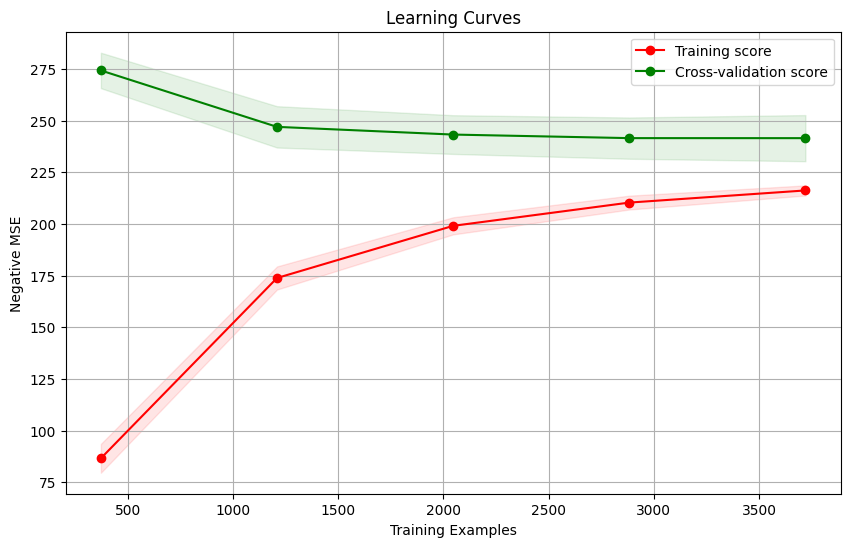

In [221]:
# Original model
original_columns = ['neutral_site', 'home_elo', 'away_elo', 'spread', 'home_talent', 'away_talent', 'home_coaches_poll_points', 'away_coaches_poll_points', 'home_ap_top_25_points', 'away_ap_top_25_points', 
               'home_cumulative_penalties', 'away_cumulative_penalties', 'home_cumulative_possession_time', 'away_cumulative_possession_time', 'home_cumulative_turnovers', 'away_cumulative_turnovers', 
               'home_cumulative_sacks', 'away_cumulative_sacks', 'home_cumulative_tackles_for_loss', 'away_cumulative_tackles_for_loss', 'home_cumulative_first_downs', 'away_cumulative_first_downs', 
               'home_cumulative_passing_TDs', 'away_cumulative_passing_TDs', 'home_cumulative_rushing_TDs', 'away_cumulative_rushing_TDs', 'home_cumulative_offense_ppa', 'home_cumulative_defense_ppa', 
               'away_cumulative_offense_ppa', 'away_cumulative_defense_ppa', 'home_cumulative_offense_success_rate', 'home_cumulative_defense_success_rate', 'away_cumulative_offense_success_rate', 
               'away_cumulative_defense_success_rate', 'home_cumulative_offense_explosiveness', 'home_cumulative_defense_explosiveness', 'away_cumulative_offense_explosiveness', 
               'away_cumulative_defense_explosiveness', 'home_cumulative_offense_points_per_opportunity', 'home_cumulative_defense_points_per_opportunity', 'away_cumulative_offense_points_per_opportunity', 
               'away_cumulative_defense_points_per_opportunity', 'home_cumulative_offense_havoc', 'home_cumulative_defense_havoc', 'away_cumulative_offense_havoc', 'away_cumulative_defense_havoc', 
               'home_conference_encoded', 'away_conference_encoded', 'home_cumulative_yards_per_completion', 'away_cumulative_yards_per_completion', 'home_cumulative_yards_per_attempt', 
               'away_cumulative_yards_per_attempt', 'home_cumulative_yards_per_carry', 'away_cumulative_yards_per_carry', 'home_returning_production_percent_passing_ppa', 'away_returning_production_percent_passing_ppa', 
               'home_returning_production_percent_receiving_ppa', 'away_returning_production_percent_receiving_ppa', 'home_returning_production_percent_rushing_ppa', 'away_returning_production_percent_rushing_ppa',
                   'home_performance_at_home', 'away_performance_at_away', 'home_vs_away_performance']

original_X = X[original_columns]
original_X_train = X_train[original_columns]
original_X_cv = X_cv[original_columns]

original_model = train_model(original_X_train, y_train, original_X_cv, y_cv)
plot_learning_curve(original_model, original_X, y)

Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 400}
Root Mean Squared Error (RMSE) of Best Model: 16.01364408065599
Mean Absolute Error (MAE) of cross validation data: 12.532721628068435


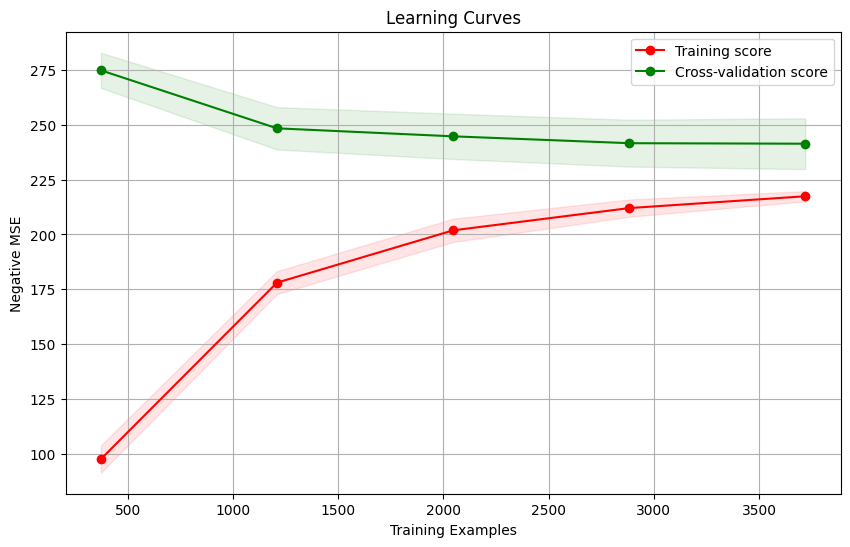

In [222]:
# Train the model with the difference of home and away features for each stat for the original features
original_features_to_diff = ['talent', 'elo', 'coaches_poll_points', 'ap_top_25_points', 'cumulative_penalties',
                    'cumulative_possession_time', 'cumulative_turnovers', 'cumulative_sacks',
                    'cumulative_tackles_for_loss', 'cumulative_first_downs', 'cumulative_passing_TDs',
                    'cumulative_rushing_TDs', 'cumulative_offense_ppa', 'cumulative_defense_ppa',
                    'cumulative_offense_success_rate', 'cumulative_defense_success_rate',
                    'cumulative_offense_explosiveness', 'cumulative_defense_explosiveness',
                    'cumulative_offense_points_per_opportunity', 'cumulative_defense_points_per_opportunity',
                    'cumulative_offense_havoc', 'cumulative_defense_havoc', 'cumulative_yards_per_completion', 'cumulative_yards_per_attempt', 'cumulative_yards_per_carry',
                    'returning_production_percent_passing_ppa', 'returning_production_percent_passing_ppa', 'returning_production_percent_receiving_ppa', 'returning_production_percent_receiving_ppa', 
                    'returning_production_percent_rushing_ppa', 'returning_production_percent_rushing_ppa']

original_additional_columns = ['neutral_site', 'spread', 'home_conference_encoded', 'away_conference_encoded', 
                               'home_performance_at_home', 'away_performance_at_away', 'home_vs_away_performance']

original_diff_X = X[original_additional_columns].copy()
original_diff_X_train = X_train[original_additional_columns].copy()
original_diff_X_cv = X_cv[original_additional_columns].copy()

for feature in original_features_to_diff:
    home_col = f'home_{feature}'
    away_col = f'away_{feature}'
    diff_col = f'diff_{feature}'
    original_diff_X[diff_col] = X[home_col] - X[away_col]
    original_diff_X_train[diff_col] = X_train[home_col] - X_train[away_col]
    original_diff_X_cv[diff_col] = X_cv[home_col] - X_cv[away_col]

original_diff_model = train_model(original_diff_X_train, y_train, original_diff_X_cv, y_cv)
plot_learning_curve(original_diff_model, original_diff_X, y)

# New Models with More Features

Best Hyperparameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
Root Mean Squared Error (RMSE) of Best Model: 16.028181212165734
Mean Absolute Error (MAE) of cross validation data: 12.528355871006767


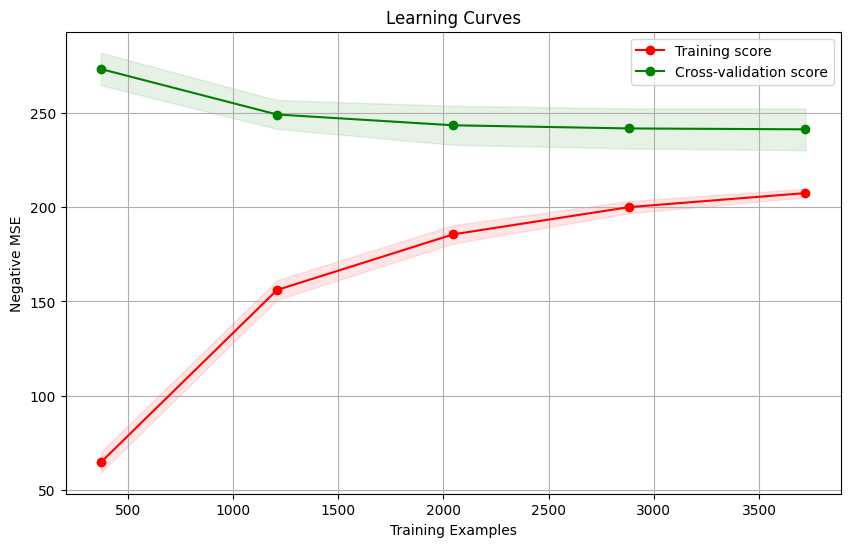

In [223]:
# Train the model with every feature
expanded_model = train_model(X_train, y_train, X_cv, y_cv)
plot_learning_curve(expanded_model, X, y)

Best Hyperparameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
Root Mean Squared Error (RMSE) of Best Model: 16.08295966961147
Mean Absolute Error (MAE) of cross validation data: 12.552944682770839


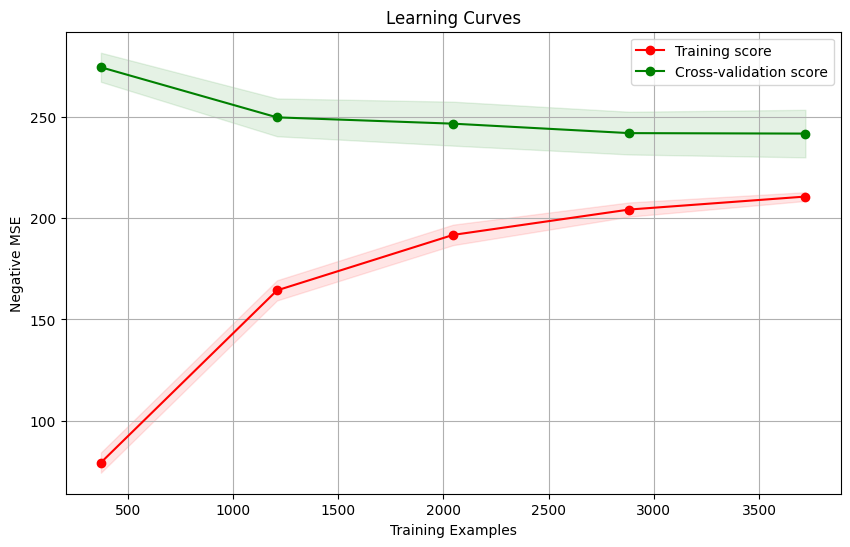

In [224]:
# Train the model with the difference of home and away features for each stat
expanded_features_to_diff = ['talent', 'elo', 'coaches_poll_points', 'ap_top_25_points', 'cumulative_penalties', 'cumulative_possession_time', 'cumulative_turnovers', 'cumulative_sacks',
                    'cumulative_tackles_for_loss', 'cumulative_first_downs', 'cumulative_third_downs', 'cumulative_fourth_downs', 'cumulative_third_down_conversions', 'cumulative_fourth_down_conversions',
                    'cumulative_pass_attempts', 'cumulative_pass_completions', 'cumulative_net_passing_yards', 'cumulative_passing_TDs', 'cumulative_rushing_attempts', 'cumulative_rushing_yards', 
                    'cumulative_rushing_TDs', 'cumulative_total_yards', 'cumulative_offense_drives', 'cumulative_defense_drives', 'cumulative_offense_ppa', 'cumulative_defense_ppa', 
                    'cumulative_offense_success_rate', 'cumulative_defense_success_rate', 'cumulative_offense_explosiveness', 'cumulative_defense_explosiveness', 
                    'cumulative_offense_points_per_opportunity', 'cumulative_defense_points_per_opportunity', 'cumulative_offense_stuff_rate', 'cumulative_defense_stuff_rate', 
                    'cumulative_offense_field_position_average_predicted_points','cumulative_defense_field_position_average_predicted_points', 'cumulative_offense_havoc', 'cumulative_defense_havoc',
                    'cumulative_yards_per_completion', 'cumulative_yards_per_attempt', 'cumulative_yards_per_carry', 'returning_production_percent_passing_ppa', 'returning_production_percent_passing_ppa', 
                    'returning_production_percent_receiving_ppa', 'returning_production_percent_receiving_ppa', 'returning_production_percent_rushing_ppa', 'returning_production_percent_rushing_ppa']

expanded_additional_columns = ['neutral_site', 'spread', 'home_conference_encoded', 'away_conference_encoded',
                              'home_performance_at_home', 'away_performance_at_away', 'home_vs_away_performance']

expanded_diff_X = X[expanded_additional_columns].copy()
expanded_diff_X_train = X_train[expanded_additional_columns].copy()
expanded_diff_X_cv = X_cv[expanded_additional_columns].copy()

for feature in expanded_features_to_diff:
    home_col = f'home_{feature}'
    away_col = f'away_{feature}'
    diff_col = f'diff_{feature}'
    expanded_diff_X[diff_col] = X[home_col] - X[away_col]
    expanded_diff_X_train[diff_col] = X_train[home_col] - X_train[away_col]
    expanded_diff_X_cv[diff_col] = X_cv[home_col] - X_cv[away_col]

expanded_diff_model = train_model(expanded_diff_X_train, y_train, expanded_diff_X_cv, y_cv)
plot_learning_curve(expanded_diff_model, expanded_diff_X, y)

# Feature Engineering more models

Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 400}
Root Mean Squared Error (RMSE) of Best Model: 16.062809550870725
Mean Absolute Error (MAE) of cross validation data: 12.563794219495367


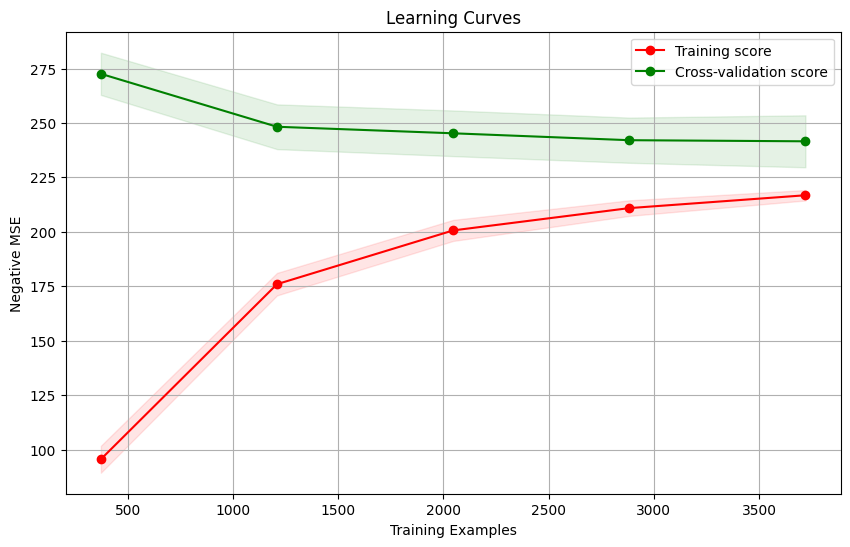

In [225]:
# Train the model with the difference of home and away features for different stats
testing_features_to_diff = ['talent', 'elo', 'coaches_poll_points', 'ap_top_25_points', 'cumulative_penalties', 'cumulative_possession_time', 'cumulative_turnovers', 'cumulative_sacks',
                    'cumulative_tackles_for_loss', 'cumulative_first_downs', 'cumulative_third_downs', 'cumulative_fourth_downs', 'cumulative_third_down_conversions', 'cumulative_fourth_down_conversions',
                    'cumulative_pass_attempts', 'cumulative_pass_completions', 'cumulative_net_passing_yards', 'cumulative_passing_TDs', 'cumulative_rushing_attempts', 'cumulative_rushing_yards', 
                    'cumulative_rushing_TDs', 'cumulative_total_yards', 'cumulative_offense_drives', 'cumulative_defense_drives', 'cumulative_offense_ppa', 'cumulative_defense_ppa', 
                    'cumulative_offense_success_rate', 'cumulative_defense_success_rate', 'cumulative_offense_explosiveness', 'cumulative_defense_explosiveness', 
                    'cumulative_offense_points_per_opportunity', 'cumulative_defense_points_per_opportunity', 'cumulative_offense_stuff_rate', 'cumulative_defense_stuff_rate', 
                    'cumulative_offense_field_position_average_predicted_points','cumulative_defense_field_position_average_predicted_points', 'cumulative_offense_havoc', 'cumulative_defense_havoc',
                    'cumulative_yards_per_completion', 'cumulative_yards_per_attempt', 'cumulative_yards_per_carry', 'returning_production_percent_passing_ppa', 'returning_production_percent_passing_ppa', 
                    'returning_production_percent_receiving_ppa', 'returning_production_percent_receiving_ppa', 'returning_production_percent_rushing_ppa', 'returning_production_percent_rushing_ppa']

testing_additional_columns = ['neutral_site', 'spread', 'home_conference_encoded', 'away_conference_encoded',
                             'home_performance_at_home', 'away_performance_at_away', 'home_vs_away_performance']

removed_features = ['cumulative_passing_TDs', 'cumulative_pass_completions', 'cumulative_pass_attempts', 'cumulative_net_passing_yards', 'cumulative_rushing_TDs', 
                    'cumulative_rushing_attempts', 'cumulative_rushing_yards', 'cumulative_first_downs', 'cumulative_third_downs', 'cumulative_fourth_downs'] 

testing_diff_X = X[testing_additional_columns].copy()
testing_diff_X_train = X_train[testing_additional_columns].copy()
testing_diff_X_cv = X_cv[testing_additional_columns].copy()

for feature in testing_features_to_diff:
    if feature not in removed_features:
        home_col = f'home_{feature}'
        away_col = f'away_{feature}'
        diff_col = f'diff_{feature}'
        testing_diff_X[diff_col] = X[home_col] - X[away_col]
        testing_diff_X_train[diff_col] = X_train[home_col] - X_train[away_col]
        testing_diff_X_cv[diff_col] = X_cv[home_col] - X_cv[away_col]

testing_diff_model = train_model(testing_diff_X_train, y_train, testing_diff_X_cv, y_cv)
plot_learning_curve(testing_diff_model, testing_diff_X, y)

# Data Visualization

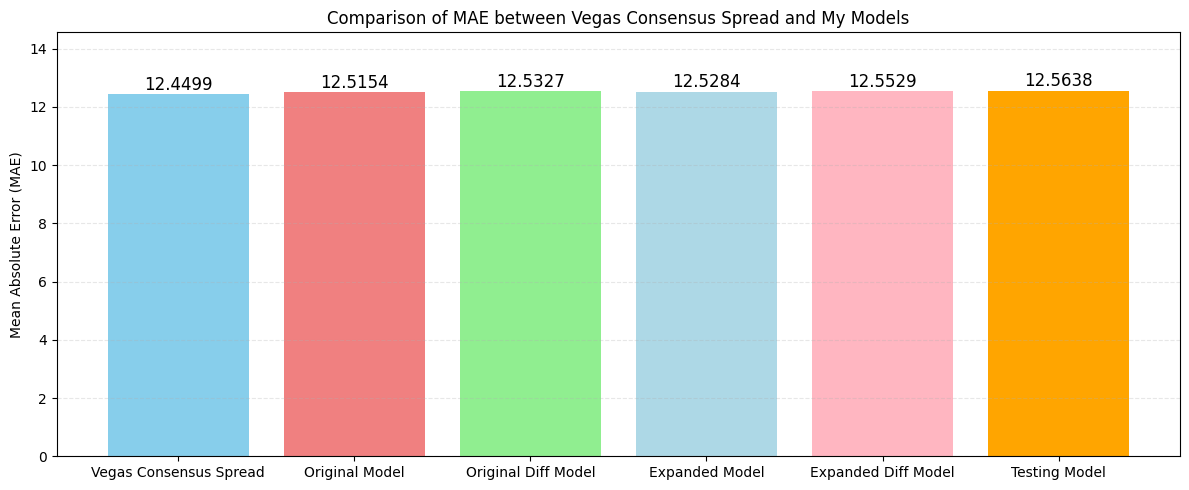

In [226]:
### MAE values for each model (replace these with your actual MAE values)
model_names = ['Vegas Consensus Spread', 'Original Model', 'Original Diff Model', 'Expanded Model', 'Expanded Diff Model', 'Testing Model']
mae_values = [vegas_mae,
              mean_absolute_error(y_cv, original_model.predict(original_X_cv)),
              mean_absolute_error(y_cv, original_diff_model.predict(original_diff_X_cv)),
              mean_absolute_error(y_cv, expanded_model.predict(X_cv)),
              mean_absolute_error(y_cv, expanded_diff_model.predict(expanded_diff_X_cv)),
              mean_absolute_error(y_cv, testing_diff_model.predict(testing_diff_X_cv))]

# Custom colors for bars
colors = ['skyblue', 'lightcoral', 'lightgreen', 'lightblue', 'lightpink', 'orange']

# Create a bar chart
plt.figure(figsize=(12, 5))
bars = plt.bar(model_names, mae_values, color=colors)
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Comparison of MAE between Vegas Consensus Spread and My Models')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Add more space between the top of the bars and the outline of the chart
extra_space = 2 # Adjust this value to control the space
plt.ylim(top=max(mae_values) + extra_space)

# Display the MAE values on top of the bars with a little offset
for bar, mae in zip(bars, mae_values):
    plt.text(bar.get_x() + bar.get_width() / 2, mae + 0.005, str(round(mae, 4)),
             ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

In [227]:
# The specific encoded conference values for power 5 teams
p5_conference_values = [0, 2, 5, 13, 14]

def plot_data(model, X_cv, y_cv):
    # Filter the CV data based on the power 5 conference values
    p5_X_cv = X_cv[(X_cv['home_conference_encoded'].isin(p5_conference_values)) & (X_cv['away_conference_encoded'].isin(p5_conference_values))]
    p5_y_cv = y_cv[(X_cv['home_conference_encoded'].isin(p5_conference_values)) & (X_cv['away_conference_encoded'].isin(p5_conference_values))]
    p5_y_pred = model.predict(p5_X_cv)
    
    # Filter the CV data based on the non-power 5 conference values
    non_p5_X_cv = X_cv[~(X_cv['home_conference_encoded'].isin(p5_conference_values)) | ~(X_cv['away_conference_encoded'].isin(p5_conference_values))]
    non_p5_y_cv = y_cv[~(X_cv['home_conference_encoded'].isin(p5_conference_values)) | ~(X_cv['away_conference_encoded'].isin(p5_conference_values))]
    non_p5_y_pred = model.predict(non_p5_X_cv)
    
    print(f"Root Mean Squared Error (RMSE) of CV Power 5 games: {mean_squared_error(p5_y_cv, p5_y_pred) ** 0.5}")
    print(f"Mean Absolute Error (MAE) of CV Power 5 games: {mean_absolute_error(p5_y_cv, p5_y_pred)}")
    print(f"Root Mean Squared Error (RMSE) of CV non-Power 5 games: {mean_squared_error(non_p5_y_cv, non_p5_y_pred) ** 0.5}")
    print(f"Mean Absolute Error (MAE) of CV non-Power 5 games: {mean_absolute_error(non_p5_y_cv, non_p5_y_pred)}")
    
    # Scatter plot for P5 teams (in blue)
    plt.figure(figsize=(8, 8))
    plt.scatter(p5_y_cv, p5_y_pred, alpha=0.5, c='blue', label='Power 5 Games')
    # Scatter plot for Non-P5 teams (in green)
    plt.scatter(non_p5_y_cv, non_p5_y_pred, alpha=0.5, c='green', label='Non-Power 5 Games')
    
    # Plot a diagonal red dashed line
    plt.plot([min(y_cv), max(y_cv)], [min(y_cv), max(y_cv)], color='red', linestyle='--', lw=2)
    plt.xlabel("Actual margin values (y_cv)")
    plt.ylabel("Predicted margin values (y_pred)")
    plt.title("Actual vs. Predicted Margin Values for Power 5 and Non-Power 5 Games")
    plt.grid(True)
    plt.legend()
    plt.show()

In [228]:
def plot_residuals(model, X_cv, y_cv):
    y_pred = model.predict(X_cv)
    residuals = y_cv - y_pred
    # Filter data for P5 and non-P5 games
    P5_residuals = residuals[(X_cv['home_conference_encoded'].isin(p5_conference_values)) & (X_cv['away_conference_encoded'].isin(p5_conference_values))]
    non_P5_residuals = residuals[~(X_cv['home_conference_encoded'].isin(p5_conference_values)) | ~(X_cv['away_conference_encoded'].isin(p5_conference_values))]
    
    # Create a residual plot with different colors
    plt.figure(figsize=(8, 8))
    plt.scatter(y_pred[(X_cv['home_conference_encoded'].isin(p5_conference_values)) & (X_cv['away_conference_encoded'].isin(p5_conference_values))], P5_residuals, alpha=0.5, label='Power 5 Games', color='blue')
    plt.scatter(y_pred[~(X_cv['home_conference_encoded'].isin(p5_conference_values)) | ~(X_cv['away_conference_encoded'].isin(p5_conference_values))], non_P5_residuals, alpha=0.5, label='Non-Power 5 Games', color='green')
    plt.axhline(y=0, color='red', linestyle='--', lw=2)  # Add a horizontal line at y=0
    
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title("Residual Plot")
    plt.grid(True)
    plt.legend()  # Add a legend to distinguish P5 and non-P5 games
    plt.show()
    
    # 2. Distribution Plot - a density plot or histogram for both the actual and predicted values on the same graph to compare their distributions
    plt.figure(figsize=(8, 8))
    sns.kdeplot(y_cv, label="Actual", fill=True)
    sns.kdeplot(y_pred, label="Predicted", fill=True)
    plt.xlabel("Values")
    plt.ylabel("Density")
    plt.title("Distribution Plot (Actual vs. Predicted)")
    plt.legend()
    plt.grid(True)
    plt.show()

In [229]:
# If "home_elo" is showing as a significant feature in one plot but not in the other, it might indicate that while it's frequently used for splitting, 
# its impact on model performance (measured in terms of reducing prediction error) might not be as high as other features. 

# First plot ranks how many times each feature is used for splitting across all of the decision trees
# Second plot not sure the difference...
def plot_feature_importances(model, X_train_columns):
    # Get feature importances
    importance_scores = model.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': X_train_columns, 'Importance': importance_scores})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)
    
    # Plot the feature importances
    plt.figure(figsize=(10, 14))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.title('Feature Importances')
    plt.show()
    
    # ”weight” is the number of times a feature appears in a tree
    fig, ax = plt.subplots(figsize=(8, 14))
    xgb.plot_importance(model, importance_type='weight', ax=ax)
    plt.title("Feature Importance Plot")
    plt.show()

In [230]:
def plot_PDPs(model, X_cv, feature_groups):
    # Create PDPs for specific features
    height_per_plot = 3
    fig, axes = plt.subplots(len(feature_groups), 2, figsize=(14, 3 * len(feature_groups)))
    
    for feature_pair in feature_groups:
        PartialDependenceDisplay.from_estimator(model, X_cv, feature_pair, ax=axes[feature_groups.index(feature_pair)])

    plt.tight_layout()

In [231]:
def plot_heatmap(X_cv):
    # 4. Error Heatmap - shows errors for different combinations of features, helping to identify feature interactions affecting the model.
    plt.figure(figsize=(18, 18))
    plt.title("Error Heatmap")
    annot_font_size = 8  # Adjust to your preference
    correlation_matrix = X_cv.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', annot_kws={"size": annot_font_size}, fmt=".1f", linewidths=0.5, linecolor='black')
    plt.show()

Root Mean Squared Error (RMSE) of CV Power 5 games: 16.11216290950601
Mean Absolute Error (MAE) of CV Power 5 games: 12.511899282346958
Root Mean Squared Error (RMSE) of CV non-Power 5 games: 16.024966188703097
Mean Absolute Error (MAE) of CV non-Power 5 games: 12.603478583197093


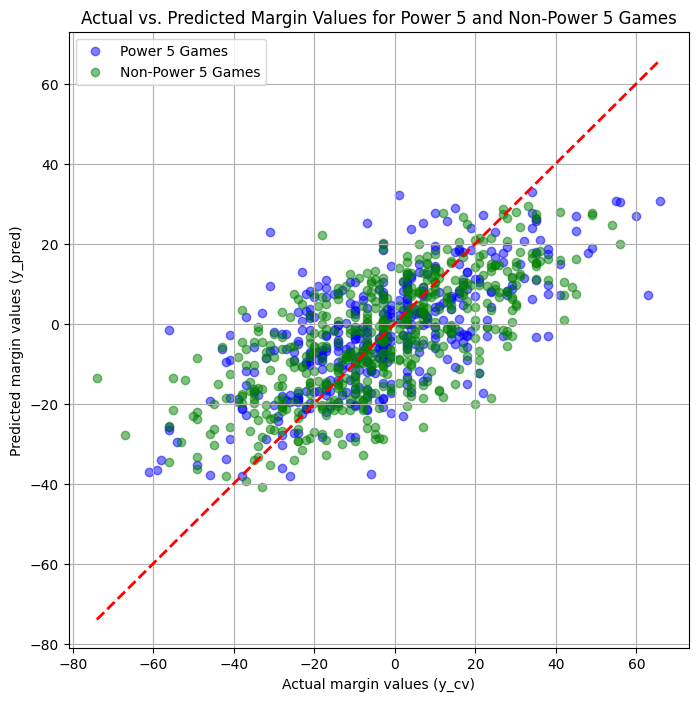

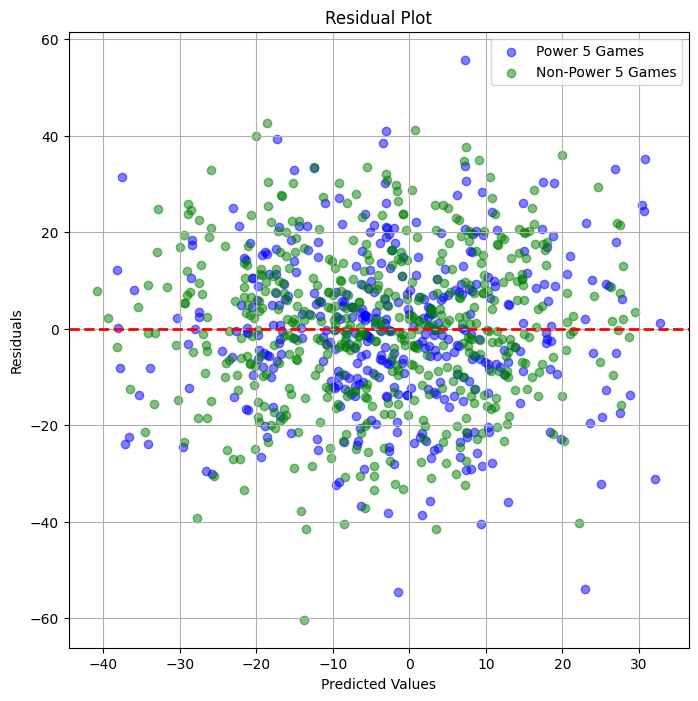

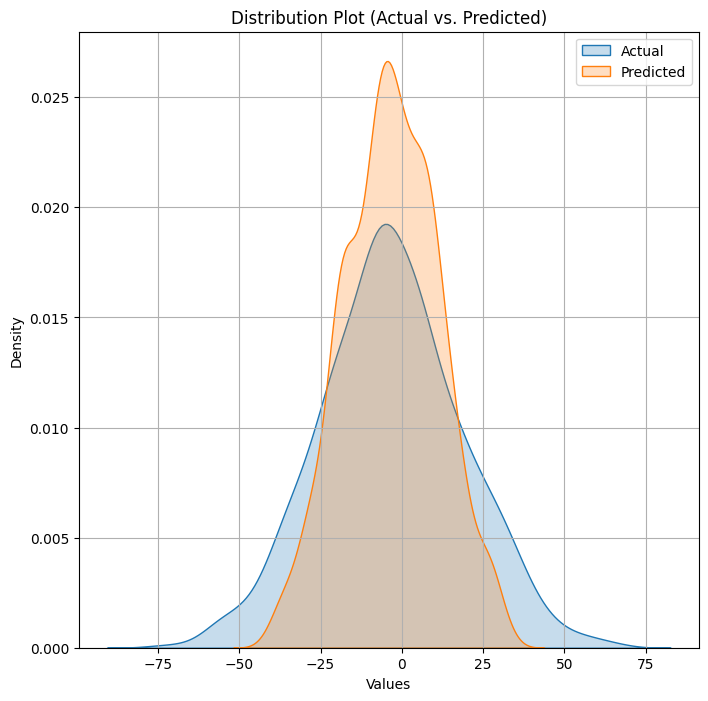

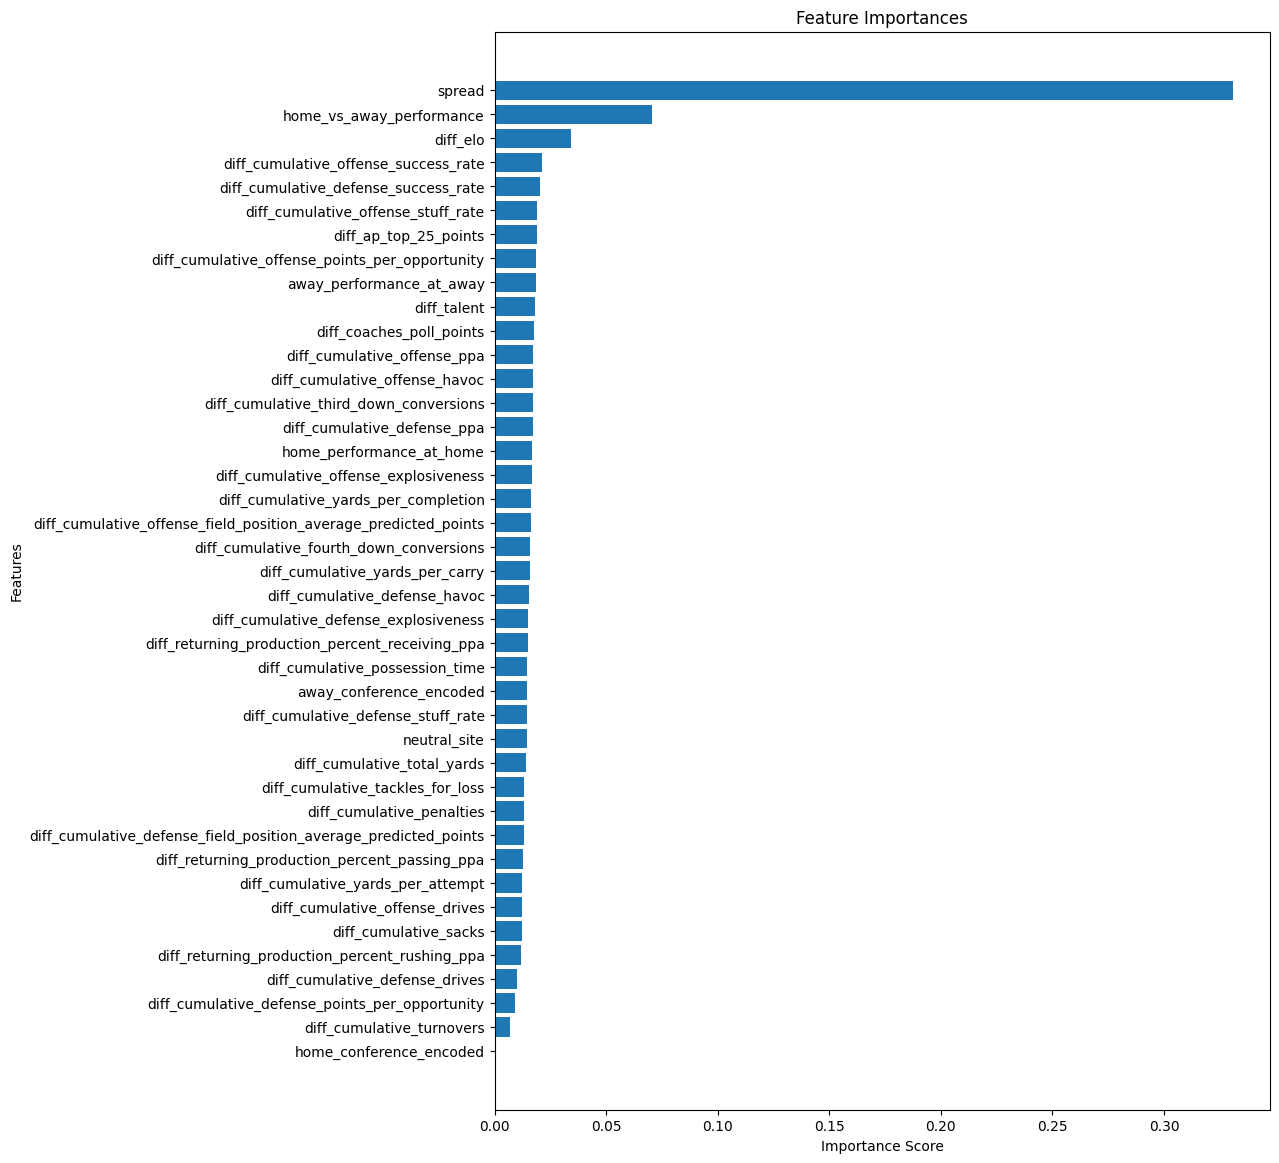

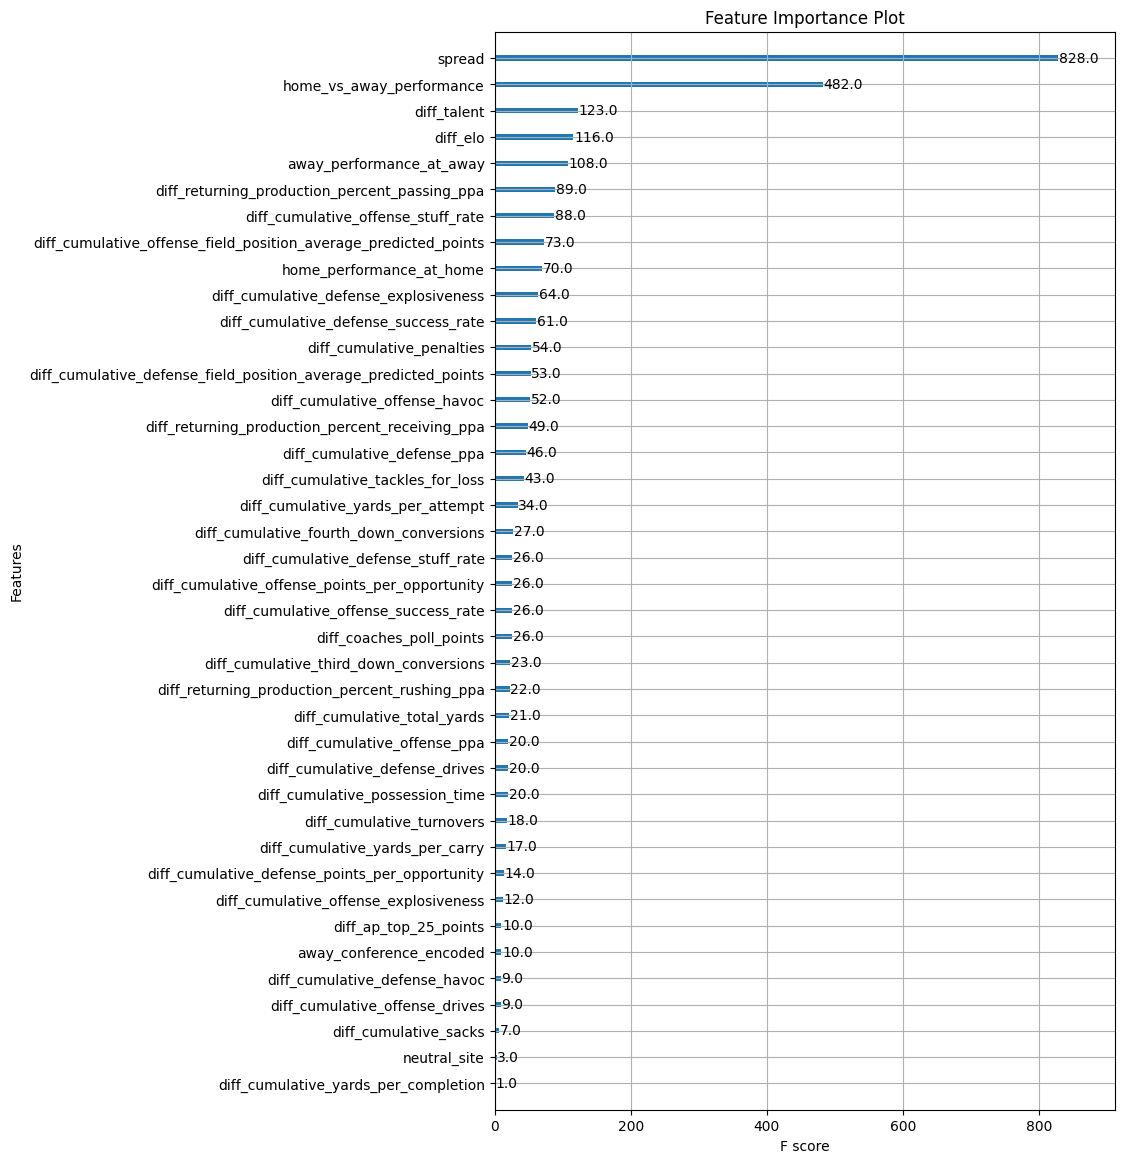

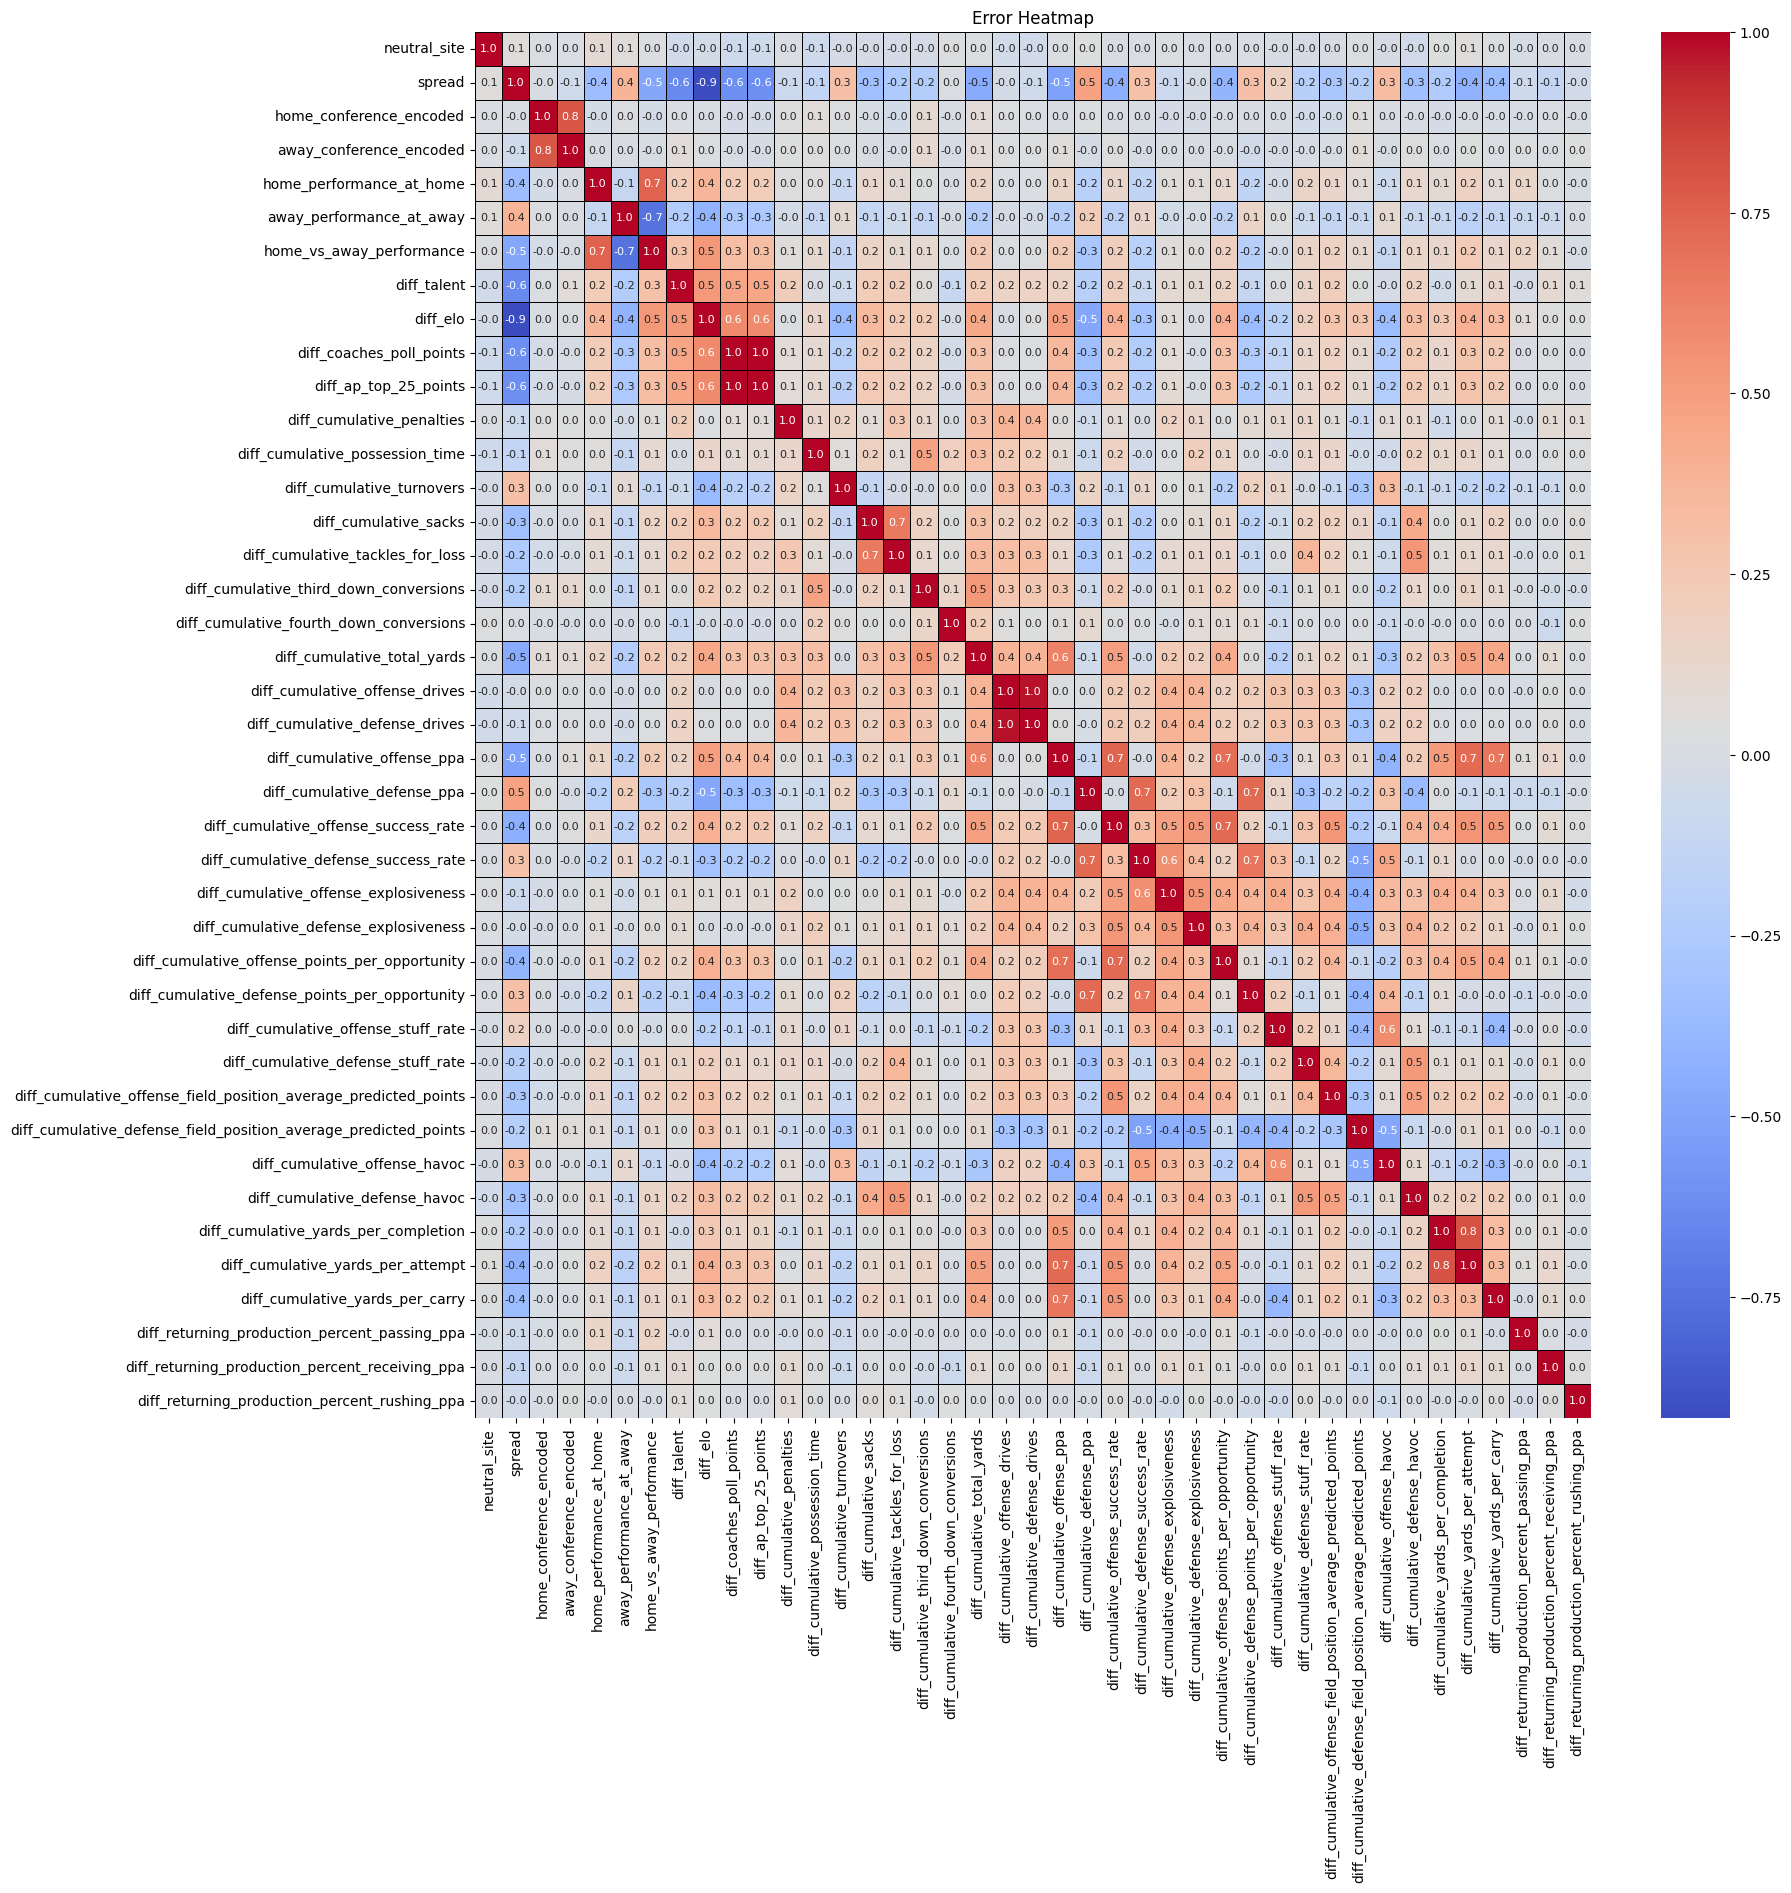

In [232]:
plot_data(testing_diff_model, testing_diff_X_cv, y_cv)
plot_residuals(testing_diff_model, testing_diff_X_cv, y_cv)
plot_feature_importances(testing_diff_model, testing_diff_X_train.columns)
plot_heatmap(testing_diff_X_cv)

In [233]:
plot_data(model, X_cv, y_cv)
plot_residuals(model, X_cv, y_cv)
plot_feature_importances(model, X_train.columns)
plot_PDPs(model, X_cv, [
            ["spread", "neutral_site"],
            ["home_talent", "away_talent"],
            ["home_elo", "away_elo"],
            ["home_coaches_poll_points", "away_coaches_poll_points"],
            ["home_ap_top_25_points", "away_ap_top_25_points"],
            ['home_cumulative_tackles_for_loss', 'away_cumulative_tackles_for_loss'],
            ['home_cumulative_sacks', 'away_cumulative_sacks'],
            ["home_cumulative_turnovers", "away_cumulative_turnovers"],
            ['home_cumulative_penalties', 'away_cumulative_penalties'],
            ['home_cumulative_passingsTDs', 'away_cumulative_passingsTDs'],
            ['home_cumulative_rushingTDs', 'away_cumulative_rushingTDs'],
            ['home_cumulative_possession_time', 'away_cumulative_possession_time'],
            ["home_cumulative_first_downs", "away_cumulative_first_downs"],
            ['home_cumulative_offense_ppa','away_cumulative_offense_ppa'],
            ['home_cumulative_defense_ppa', 'away_cumulative_defense_ppa'],
            ['home_cumulative_offense_success_rate', 'away_cumulative_offense_success_rate'],
            ['home_cumulative_defense_success_rate', 'away_cumulative_defense_success_rate'],
            ['home_cumulative_offense_explosiveness', 'away_cumulative_offense_explosiveness'],
            ['home_cumulative_defense_explosiveness', 'away_cumulative_defense_explosiveness'],
            ['home_cumulative_offense_points_per_opportunity', 'away_cumulative_offense_points_per_opportunity'],
            ['home_cumulative_defense_points_per_opportunity', 'away_cumulative_defense_points_per_opportunity'],
            ['home_cumulative_offense_havoc', 'away_cumulative_offense_havoc'],
            ['home_cumulative_defense_havoc', 'away_cumulative_defense_havoc']
        ])
plot_heatmap(X_cv)

ValueError: Feature shape mismatch, expected: 80, got 134

In [ ]:
plot_data(diff_model, diff_X_cv, y_cv)
plot_residuals(diff_model, diff_X_cv, y_cv)
plot_feature_importances(diff_model, diff_X_train.columns)
plot_PDPs(diff_model, diff_X_cv, [
            ["spread", "neutral_site"],
            ["diff_talent", "diff_elo"],
            ["diff_coaches_poll_points", "diff_ap_top_25_points"],
            ["diff_cumulative_tackles_for_loss", 'diff_cumulative_sacks'],
            ['diff_cumulative_turnovers', 'diff_cumulative_penalties'], 
            ['diff_cumulative_passing_TDs', 'diff_cumulative_rushing_TDs'],
            ['diff_cumulative_possession_time', "diff_cumulative_first_downs"], 
            ['diff_cumulative_offense_ppa', 'diff_cumulative_defense_ppa'],
            ['diff_cumulative_offense_success_rate', 'diff_cumulative_defense_success_rate'],
            ['diff_cumulative_offense_explosiveness', 'diff_cumulative_defense_explosiveness'],
            ['diff_cumulative_offense_points_per_opportunity', 'diff_cumulative_defense_points_per_opportunity'],
            ['diff_cumulative_offense_havoc', 'diff_cumulative_defense_havoc']
        ])
plot_heatmap(diff_X_cv)